In [1]:
import os
import sys

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Now you can import the module from the examples directory
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from l2ws.l2ws_model import L2WSmodel
from l2ws.algo_steps import cold_start_solve

/Users/rajivs/Documents/Princeton/l2ws_conic/env/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


## Projected gradient descent

<!-- &\\ \quad z \in \mathcal{C} -->

In this tutorial we show how to use our package to learn high-quality warm starts for your favorite fixed-point algorithm.
We consider projected gradient descent to solve the problem

\begin{equation*}
\begin{array}{ll} \text{minimize} &f_\theta(z)\\
\text{subject to} & z \in \mathcal{C},
 \end{array}
\end{equation*}
where $z \in \mathbf{R}^n$ is the decision variable, $f_\theta : \mathbf{R}^n \rightarrow \mathbf{R}$ is a convex function and $L$-smooth function.

The iterates of projected gradient descent are
\begin{equation*}
    z^{i+1} = \Pi_{\mathcal{C}}(z^i - \alpha \nabla f_\theta(z^i)).
\end{equation*}

We take the specific example of non-negative least squares

\begin{equation*}
\begin{array}{ll} \text{minimize} &\|Az-b\|_2^2\\
\text{subject to} & z \geq 0,
 \end{array}
\end{equation*}
where $A \in \mathbf{R}^{m \times n}$ and $b \in \mathbf{R}^{m}$ are problem data.
Here, $\theta = b$ is the parameter.

In [2]:
# setup
N_train = 5000
N_test = 100
N = N_train + N_test
m, n = 50, 25

# generate a single random A matrix
A = jnp.array(np.random.normal(size=(m, n)))

# generate N different b vectors
b_mat = jnp.array(np.random.normal(size=(N, m)))

evals, evecs = jnp.linalg.eigh(A.T @ A)
step = 1 / jnp.max(evals)

# the b vectors are the parameters
b_mat_train = b_mat[:N_train, :]
b_mat_test = b_mat[N_train:, :]

# the inputs are the parameters, but can be normalized
train_inputs = b_mat_train
test_inputs = b_mat_test

In [3]:
# code up the fixed-point algorithm
def proj_gd_fixed_point(z, theta):
    return jnp.clip(z - step * A.T @ (A @ z - theta), a_min=0)

In [4]:
# solve all of the problems to get z_stars_train and z_stars_test

# pass the following:
# 1. fixed-point function
# 2. the size of the z variable
# 3. the matrix of parameters (theta = b here) 

# returns the following:
# 1. z_finals: matrix of solutions 
# 2. iter_losses: a vector of the average fixed-point residuals over the iterations
z_finals, iter_losses = cold_start_solve(proj_gd_fixed_point, n, b_mat)

z_stars_train = z_finals[:N_train, :]
z_stars_test = z_finals[N_train:, :]

In [5]:
# create a ProjGDmodel object that inherits from the L2WSmodel
class ProjGDmodel(L2WSmodel):
    def __init__(self, **kwargs):
        super(ProjGDmodel, self).__init__(**kwargs)

    def initialize_algo(self, input_dict):
        self.algo = 'proj_gd'

        # now set the parameters
        self.theta_mat_train, self.theta_mat_test = input_dict['b_mat_train'], input_dict['b_mat_test']

        # n is the size of the z variable in this case
        self.output_size = input_dict['n']

        # set the fixed-point function
        self.fixed_point_fn = input_dict['fixed_point_fn']


In [6]:
# set the neural network config
#   by default it uses adam with learning rate 1e-3
#   here, we use 1 hidden layer with relu activation with 100 neurons
nn_cfg = {'intermediate_layer_sizes': [100]}
train_unrolls = 15
algo_dict = dict(algorithm='proj_gd',
                    b_mat_train=b_mat_train, 
                    b_mat_test=b_mat_test,
                    n=n,
                    fixed_point_fn=proj_gd_fixed_point
                    )
proj_gd_model = ProjGDmodel(train_unrolls=train_unrolls, 
                     train_inputs=train_inputs, 
                     test_inputs=test_inputs,
                     z_stars_train=z_stars_train,
                     z_stars_test=z_stars_test,
                     regression=False,
                     nn_cfg=nn_cfg,
                     algo_dict=algo_dict)

In [7]:
# cold start evaluation
eval_iters = 100
init_eval_out = proj_gd_model.evaluate(
    eval_iters, test_inputs, b_mat_test, z_stars=z_stars_test, fixed_ws=False)
init_test_losses = init_eval_out[1][1].mean(axis=0)

In [8]:
# train the proj_gd_model
params, state = proj_gd_model.params, proj_gd_model.state
num_epochs = 1000
train_losses = jnp.zeros(num_epochs)
for i in range(num_epochs):
    train_result = proj_gd_model.train_full_batch(params, state)
    loss, params, state = train_result
    train_losses = train_losses.at[i].set(loss)

proj_gd_model.params, proj_gd_model.state = params, state

# full evaluation on the test set
final_eval_out = proj_gd_model.evaluate(
    eval_iters, test_inputs, b_mat_test, z_stars=z_stars_test, fixed_ws=False)
final_test_losses = final_eval_out[1][1].mean(axis=0)

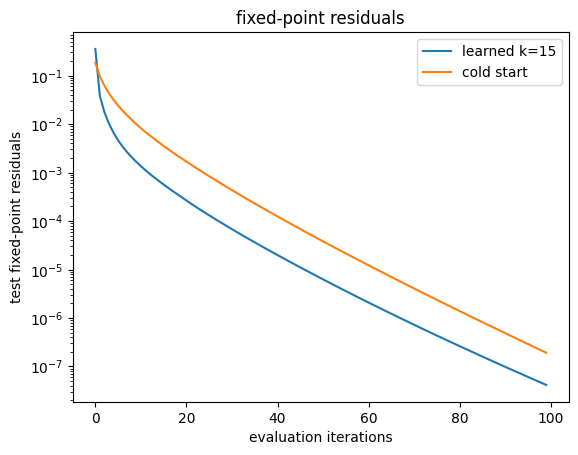

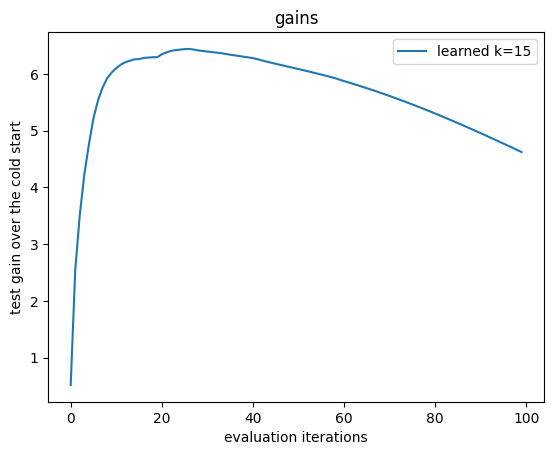

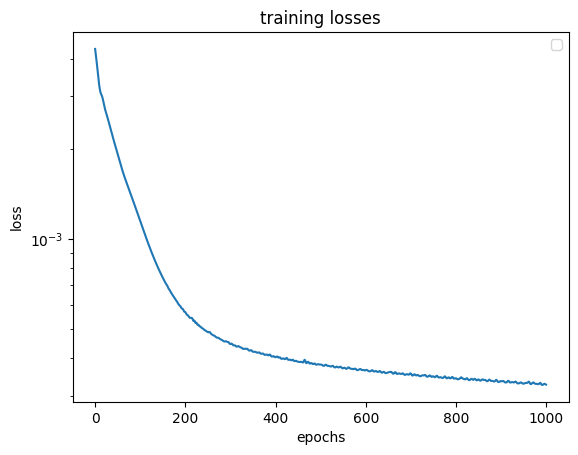

In [10]:
plt.plot(final_test_losses, label=f"learned k={train_unrolls}")
plt.plot(init_test_losses, label='cold start')
plt.yscale('log')
plt.title('fixed-point residuals')
plt.ylabel('test fixed-point residuals')
plt.xlabel('evaluation iterations')
plt.legend()
plt.show()

plt.plot(init_test_losses / final_test_losses, label=f"learned k={train_unrolls}")
plt.title('gains')
plt.ylabel('test gain over the cold start')
plt.xlabel('evaluation iterations')
plt.legend()
plt.show()

plt.plot(train_losses)
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.yscale('log')
plt.title('training losses')
plt.legend()
plt.show()